In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
SED = 'Data_files/ARM2_HII2_stitch.dat'
raw_file = np.genfromtxt('Data_files/intrat.out_1e3_8e3', skip_header = 3)
column_names = ['WL (microns)', 'flux density', 'transition (from, to)', 'electron density', 'effective temperature']
WL_reduced = raw_file[:,0]
flux_reduced = raw_file[:,1]
transition_reduced = []
for i in range(0,len(flux_reduced)):
    transition_reduced.append([raw_file[i,3],raw_file[i,5]])
e_density = raw_file[0,7]
Teff = raw_file[0,9]

In [4]:
print(transition_reduced[1])
print(flux_reduced[1])
print(get_transition_flux(4,3))
print(get_transition_flux(5,3))
print(get_ratio(5,3,4,3))
a = []
a.append('string')
print(a)

[7.0, 3.0]
8.533e-27


NameError: name 'get_transition_flux' is not defined

In [5]:
def get_transition_flux(From, To):
    answer = []
    for i in range(0,len(transition_reduced)):
        if transition_reduced[i][0]==From and transition_reduced[i][1]==To:
            answer.append(flux_reduced[i])
    if len(answer)>1:
        print(f'Multiple fluxes recorded as {From} -> {To} transitions')
        return answer
    elif len(answer)==0:
        if To <3:
            print('Only Balmer and above final energy levels are included in this dataset')
        print(f'No results detected for {From} -> {To} transition')
    else:
        return answer[0]
print(get_transition_flux(4,3))
print(get_transition_flux(5,3))
def get_ratio(From_numerator, To_numerator, From_denominator, To_denominator):
    return get_transition_flux(From_numerator,To_numerator)/get_transition_flux(From_denominator,To_denominator)
print(get_ratio(4,3,5,3))


5.368e-26
2.544e-26
2.110062893081761


In [6]:
# Function to import the dataset and process it
def import_data(file_path):
    data_list = []

    # Open the file and process each line manually
    with open(file_path, 'r') as file:
        # Read the header (first line)
        header = file.readline().strip().split()

        # Process each line
        for line in file:
            # Split the line into parts (split at spaces)
            parts = line.strip().split(maxsplit=4)
            
            # If the 5th part (notes) is missing, append NaN
            if len(parts) < 5:
                parts.append(np.nan)
            
            data_list.append(parts)

    # Convert the list into a pandas DataFrame
    data = pd.DataFrame(data_list, columns=header)

    # Convert the DataFrame to a NumPy array
    data_array = data.to_numpy()

    return data_array

# Example usage: provide the path to the .dat file
data_array = import_data(SED)

print(data_array[58,4])
mask = data_array[:,3].astype(int)
WL = data_array[:,0].astype(float)
WL_masked = np.where(mask == 1, WL, np.nan)
intens = data_array[:,1].astype(float)
intens_masked = np.where(mask == 1, intens, np.nan)

intens_uncert = data_array[:,2].astype(float)
intens_uncert_masked = np.where(mask == 1, intens_uncert, np.nan)

notes = data_array[:,4]

def gaussian_func(x, amplitude, xmean, stddev):
    return (amplitude * np.exp(-0.5 * ((x - xmean) / stddev)**2)) + 1
def find_closest_index(h_WL):
    # Calculate the absolute difference between each element in WL and h_WL
    difference = np.abs(WL - h_WL)
    
    # Find the index of the minimum difference
    closest_index = np.argmin(difference)
    
    return closest_index


H 7-3 Pa delta 1.0049 -> 1.0066


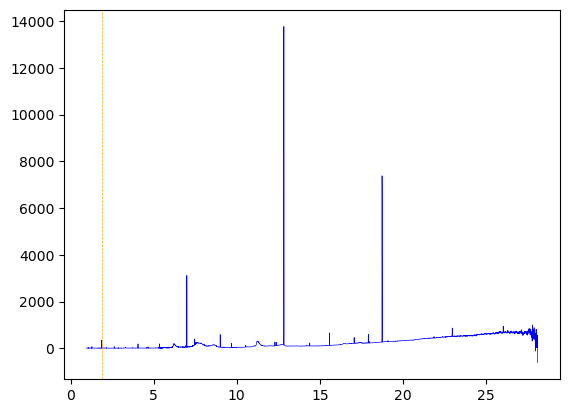

In [12]:
start = 0
end = len(WL)
mask_test = mask[start:end]
WL_test = WL[start:end]
WL_test_masked = np.where(mask_test == 1, WL_test, np.nan)

intens_test = intens[start:end]
intens_test_masked = np.where(mask_test == 1, intens_test, np.nan)

mask_test = mask[start:end]
xrange = range(0,len(intens_test))
#plt.plot(WL_test_masked, intens_test_masked, linewidth = 1, color = 'red')
plt.plot(WL_test, intens_test, linewidth = 0.5, color = 'blue')
plt.axvline(x=1.875621, color='orange', linestyle='--', linewidth=0.5, label = '32 min 3rd harmonic')

plt.show()

In [8]:
def get_feature_flux(target_WL):
    closest_index = np.argmin(np.abs(WL - target_WL))
    if mask[closest_index]==0:
        counter = 0
        print("Target wavelength was not part of a feature, trying next wavelength...")
        while mask[closest_index]==0 and counter < 3:
            closest_index+=1
            counter +=1
    if counter == 3:
        print(f"could not identify feature at this wavelength {target_WL}")
        return None
    start_index = closest_index
    end_index = closest_index
    while start_index > 0 and mask[start_index] == 1:
        start_index -= 1
    # Correct the index to include the first valid point
    if mask[start_index] == 0:
        start_index += 1
    
    # Search to the right (increasing index) until a 0 in the mask is found
    while end_index < len(WL) - 1 and mask[end_index] == 1:
        end_index += 1
    # Correct the index to include the last valid point
    if mask[end_index] == 0:
        end_index -= 1
    
    # Extract the wavelengths part of the feature
    WL_feature = WL[start_index:end_index + 1]
    
    flux = np.trapz(intens[start_index:end_index+1], WL_feature)

    return flux
for i in range(0,10):
    
    flux = get_feature_flux(WL_reduced[i])
    print(f"The area under the emission feature at {WL_reduced[i]}microns is: {flux}")

def find_max(minimum, maximum):
    find_max_mask = (WL >= minimum) & (WL <= maximum)
    return np.max(intens[find_max_mask])
find_max(1.80,1.90)

Target wavelength was not part of a feature, trying next wavelength...
could not identify feature at this wavelength 0.954861
The area under the emission feature at 0.954861microns is: None
Target wavelength was not part of a feature, trying next wavelength...
The area under the emission feature at 1.005215microns is: 0.02894425505999746
Target wavelength was not part of a feature, trying next wavelength...
The area under the emission feature at 1.094112microns is: 0.04358933166000091
Target wavelength was not part of a feature, trying next wavelength...
The area under the emission feature at 1.282163microns is: 0.1108085150999943
Target wavelength was not part of a feature, trying next wavelength...
The area under the emission feature at 1.875621microns is: 0.5596497206760062
Target wavelength was not part of a feature, trying next wavelength...
could not identify feature at this wavelength 1.468603
The area under the emission feature at 1.468603microns is: None
Target wavelength was 

348.2473

In [ ]:
WL_reduced[0]